In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ Define feature groups
# ============================================================

TLX_features = [
    'Mental Demand','Physical Demand','Temporal Demand',
    'Performance','Effort','Frustration'
]

Biosignal_features = [
    # EEG
    'mean_δ','mean_θ','mean_α','mean_β','mean_γ',
    'α/θ','θ/α','frontal_α_asy','δ_asy','θ_asy','α_asy','β_asy','γ_asy',
    # HRV
    'HRV_MeanNN','HRV_SDNN','HRV_RMSSD',
    'HRV_LFn','HRV_HFn','HRV_ratio_LFn_HFn',
    # EDA
    'SCR_Peaks_N','SCR_Peaks_Amplitude_Mean',
    # Temperature
    'mean_temp','std_temp'
]

targets = ['fatigue', 'stress', 'focus']

In [51]:
# ==========================
# 2️⃣ Load dataset
# ==========================
train_path = "/content/drive/MyDrive/universe_ml/train/train_dataset.csv"
test_path  = "/content/drive/MyDrive/universe_ml/test/test_dataset.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
# Combine all into one DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)

print("Dataset loaded ✔")
print(df.shape)



Dataset loaded ✔
(87166, 32)


In [52]:
# ============================================================
# 3️⃣ Function to train & evaluate a model
# ============================================================

def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(
        n_estimators=200,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, r2, rmse

In [53]:
# ============================================================
# 4️⃣ RUN models for each TARGET
# ============================================================

results = {'Target': [], 'Model': [], 'R2': [], 'RMSE': []}

for target in targets:
    print("\n====================================")
    print(f"   RESULTS FOR TARGET: {target.upper()}")
    print("====================================")

    # ----- TLX-only -----
    X_tlx = df[TLX_features]
    y = df[target]

    model_tlx, r2_tlx, rmse_tlx = evaluate_model(X_tlx, y)

    print(f"\nTLX-only model:")
    print(f"➡ R² = {r2_tlx:.3f}")
    print(f"➡ RMSE = {rmse_tlx:.3f}")

    results['Target'].append(target)
    results['Model'].append("TLX_only")
    results['R2'].append(r2_tlx)
    results['RMSE'].append(rmse_tlx)


    # ----- Biosignals-only -----
    X_bio = df[Biosignal_features]

    model_bio, r2_bio, rmse_bio = evaluate_model(X_bio, y)

    print(f"\nBiosignals-only model:")
    print(f"➡ R² = {r2_bio:.3f}")
    print(f"➡ RMSE = {rmse_bio:.3f}")

    results['Target'].append(target)
    results['Model'].append("Biosignals_only")
    results['R2'].append(r2_bio)
    results['RMSE'].append(rmse_bio)


# Table
results_df = pd.DataFrame(results)
print("\n\n========== SUMMARY TABLE ==========\n")
print(results_df)


   RESULTS FOR TARGET: FATIGUE

TLX-only model:
➡ R² = 1.000
➡ RMSE = 0.181

Biosignals-only model:
➡ R² = -0.025
➡ RMSE = 29.974

   RESULTS FOR TARGET: STRESS

TLX-only model:
➡ R² = 0.999
➡ RMSE = 0.044

Biosignals-only model:
➡ R² = -0.004
➡ RMSE = 1.592

   RESULTS FOR TARGET: FOCUS

TLX-only model:
➡ R² = 0.999
➡ RMSE = 0.044

Biosignals-only model:
➡ R² = -0.004
➡ RMSE = 1.647


========== SUMMARY TABLE ==========

    Target            Model        R2       RMSE
0  fatigue         TLX_only  0.999963   0.181183
1  fatigue  Biosignals_only -0.025447  29.973525
2   stress         TLX_only  0.999236   0.043895
3   stress  Biosignals_only -0.003832   1.591607
4    focus         TLX_only  0.999287   0.043895
5    focus  Biosignals_only -0.003817   1.646982


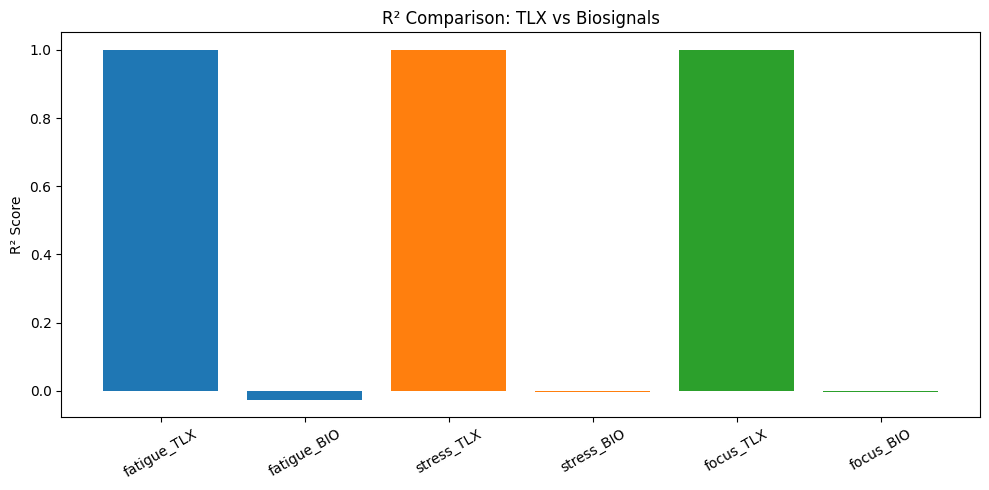

In [54]:
# ============================================================
# 5️⃣ PLOT R² comparison
# ============================================================

plt.figure(figsize=(10,5))

for target in targets:
    subset = results_df[results_df['Target'] == target]
    plt.bar(
        [f"{target}_TLX", f"{target}_BIO"],
        subset['R2']
    )

plt.title("R² Comparison: TLX vs Biosignals")
plt.ylabel("R² Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [55]:
# ============================================================
# 6️⃣ AUTOMATIC INTERPRETATION
# ============================================================

def interpret(target):
    r2_tlx  = results_df[(results_df.Target == target) & (results_df.Model == "TLX_only")]['R2'].values[0]
    r2_bio  = results_df[(results_df.Target == target) & (results_df.Model == "Biosignals_only")]['R2'].values[0]

    print("\n--------------------------------------------------")
    print(f"AUTOMATIC INTERPRETATION FOR: {target.upper()}")
    print("--------------------------------------------------")

    if r2_tlx > 0.8 and r2_bio < 0.3:
        print(f"➡ {target.capitalize()} is mainly explained by **TLX questionnaire**.")
        print("➡ Biosignals contribute very little → label not physiological.")
    elif r2_bio > r2_tlx:
        print(f"➡ {target.capitalize()} is mainly driven by **physiological signals**.")
    elif r2_bio < 0.1:
        print(f"➡ Biosignals fail → label noisy or inconsistent across subjects.")
    else:
        print(f"➡ Mixed signal: TLX + biosignals both contribute.")


for target in targets:
    interpret(target)


--------------------------------------------------
AUTOMATIC INTERPRETATION FOR: FATIGUE
--------------------------------------------------
➡ Fatigue is mainly explained by **TLX questionnaire**.
➡ Biosignals contribute very little → label not physiological.

--------------------------------------------------
AUTOMATIC INTERPRETATION FOR: STRESS
--------------------------------------------------
➡ Stress is mainly explained by **TLX questionnaire**.
➡ Biosignals contribute very little → label not physiological.

--------------------------------------------------
AUTOMATIC INTERPRETATION FOR: FOCUS
--------------------------------------------------
➡ Focus is mainly explained by **TLX questionnaire**.
➡ Biosignals contribute very little → label not physiological.
